# Analysis of Median Household Income and Climate on Crime in the U.S. States (1999-2019)
#### Niko Zhang and Sophie Tsai

## Introduction
In this tutorial, our aim is to guide you through the complete data science pipeline, which includes data curation, exploratory data analysis, hypothesis testing, and machine learning. For this tutorial, we will analyze crime rates in the United States at the state level, exploring the impact of household income and climate on the incidence of crime. Our team has obtained the necessary data from the U.S. Census Bureau for household income, the FBI Uniform Crime Reporting (UCR) program for crime, and the National Oceanic and Atmospheric Administration (NOAA) for climate.

### Why is our project relevant?
As a team, we understand that crime is a complex issue influenced by various factors, including economic and environmental conditions. According to the [FBI](https://ucr.fbi.gov/hate-crime/2011/resources/variables-affecting-crime), household income and climate are some of the factors that can affect the rate of crime. Through this project, we aim to validate these claims and uncover any correlations between crime rates and household income and climate. The insights gained from this analysis can provide policymakers with valuable information on how to implement effective crime prevention measures.

Our team hopes that through this project, we can demonstrate the power of data-driven insights in understanding complex social phenomena like crime and informing evidence-based policy decisions.

## Imports and Configurations 

In [1]:
# Imports for reading in data
import pandas as pd
import numpy as np

# Imports for using regex and strings methods
import re
import string

# Imports for exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None) # Set max rows displayed in DataFrame
pd.set_option('display.max_columns', None) # Set max columns displayed in DataFrame

# turn off SettingWithCopyWarning
pd.options.mode.chained_assignment = None
# turn off deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Collection
We begin by obtaining the relevant raw data on the state level in the form of Excel and CSV files. These files have been downloaded and organized in a folder named 'data' within our workspace for easy access.

### Crime Data
To obtain the necessary Excel files for our crime data from the FBI's UCR program, follow these steps:

1. Go to https://www.fbi.gov/how-we-can-help-you/more-fbi-services-and-information/ucr/publications.
2. Under the section titled 'Crime in the United States,' look for a list of links for years 1999 to 2019.
3. Click on each link from 1999 to 2019 and look for the download link that downloads the table for offenses by US state. Keep in mind that some UCR webpages only allow downloading all the tables at once as a compressed file.
4. Click on the download link and move the Excel file containing offenses by US state into our workspace's 'data' folder. We organized our Excel files further by placing each file into a folder for its designated year, but this is optional.

### Household Income Data
We retrieved the household income data from the U.S. Census Bureau. To obtain the Excel file for household income, go to https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html and click the download link under section 'Table H-8. Median Household Income by State' Move the Excel file into our 'data' folder.

### Climate Data
All of the climate data was obtained from the National Centers for Environmental Information [(NCEI)](https://www.ncei.noaa.gov/), a long-term archive for all National Oceanic and Atmospheric Administration [(NOAA)](https://www.noaa.gov/) coastal tide gauge data. The datasets can be found at https://www.ncei.noaa.gov/pub/data/cirs/climdiv/.

We decided to include five factors at the statewide monthly level that may impact crime incidents, including
1. Average temperature (deg. F. to 10ths): *climdiv-tmpcst-vx.y.z-YYYYMMDD*
2. Maximum temperature (deg. F. to 10ths): *climdiv-tmaxst-vx.y.z-YYYYMMDD*
3. Minimum temperature (deg. F. to 10ths): *climdiv-tminst-vx.y.z-YYYYMMDD*
4. Precipitation (inches to 100ths): *climdiv-pcpnst-vx.y.z-YYYYMMDD*
5. Palmer Drought Severity Index (PDSI): *climdiv-pdsist-vx.y.z-YYYYMMDD*

Here, we are gathering the raw datasets from the corresponding links. Because the data is updated monthly, and therefore so are the URLs, we have also saved the data as CSVs in our 'data' folder for convenience. 

In [2]:
urls = ['https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmpcst-v1.0.0-20230406', 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmaxst-v1.0.0-20230406',
        'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tminst-v1.0.0-20230406', 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-pcpnst-v1.0.0-20230406', 
        'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-pdsist-v1.0.0-20230406']
file_names = ['tmpcst.csv', 'tmaxst.csv', 'tminst.csv', 'pcpnst.csv', 'pdsist.csv']

for i in range(len(urls)): 
    # read data from links as a pandas dataframe, ensuring that the first column's leading zeros for the state code are not removed
    climate_raw = pd.read_csv(urls[i], delim_whitespace=True, converters={0: str}, header=None) 
    climate_raw.to_csv('data/climate_data/' + file_names[i], index=False) # save as csv into the data folder with the corresponding file name

## Data Preprocessing
Now that we've collected all of our data, we must clean and format each of the grouped datasets individually so we can merge them all together. To do this, we make heavy use of Pandas and NumPy to manipulate our DataFrames.

### Curating crime data by state (1999-2019)

You should always first look through the raw data to see if there are any recurring patterns/formats you can exploit to make data curation easier. If we look through the Excel files obtained from FBI's UCR program, you'll find that the data for years 2005-2019 are stored in a different format from the data for years 1999-2004. Because data for years 1999-2019 is stored mostly in the same format, we can create a function that curates the data for us rather than curating each year's data individually. 

The function below takes in one of our DataFrames from our crime data and curates it based on the two formats that our raw data is stored in.

In [3]:
'''
This function curates crime data based on the 2 predetermined formats that the data is stored in.
df: the DataFrame we want to curate
year: the year the data was collected from
version: put in 1 for curating data from 2005-2019 (newer format)
         put in 2 for curating data from 1999-2004 (older format)
state_names: list of state names that need to be appended as a new column to the DataFrames from 
             years 1999-2004 due to the way the raw data is stored
'''
def clean_crime_data(df, year, version, state_names):
    
    # version 1 is for datatables in newer format (2005-2019)
    if (version == 1):

        '''The US state column in the Excel file has merged cells. When reading this file as a 
        DataFrame, the corresponding column has NaN values due to the merged cells separating 
        into unmerged cells. The line below fixes the issue by filling in those NaN values
        with the correct US states.'''
        df[df.columns[0]] = df[df.columns[0]].fillna(method='ffill', axis=0)

        # Remove the rows that are not part of the data table
        df = df[df.isin(['State Total', 'Total', 'Rate per 100,000 inhabitants']).any(axis=1)]
        
        # Remove unnecessary columns
        df = df.iloc[:, :14]
        if year < 2013 or year > 2016:
            df = df.iloc[:, :13] # remove last column if not in years 2013-2016
        
        # combine columns at indices 1 and 2
        df.iloc[:,1:3] = df.iloc[:,1:3].fillna('')
        df.insert(1, 'unit_type', df.iloc[:,2]+df.iloc[:,1])
        df.drop(df.columns[2:4], axis=1, inplace=True)

        # if number of columns is greater than 12, it means there are 2 columns for rape,
        # since the definition of 'rape' was changed at some point in time
        if len(df.columns) > 12:
            # drop the column for the old definiton of 'rape'
            df.drop(df.columns[6], axis=1, inplace=True)

        # set column names
        df.columns = ['state','unit_type','population','violent_crime','murder_and_nonnegligent_manslaughter','rape','robbery','aggravated_assault','property_crime','burglary','larcenytheft','motor_vehicle_theft']

        # add column for year
        df.insert(0, 'year', year)

        # remove all non-characters from state names
        df['state'] = df['state'].str.replace(r'\d|,', '', regex=True).str.title()

        # Reset the indices
        df.reset_index(drop=True, inplace=True) 

    # version 2 is for datatables in older format (1999-2004)
    elif (version == 2):
        
        # Remove unnecessary columns
        if (year < 2003):
            df.replace(0, np.nan, inplace=True) # replace all zeros with NaN
            df=df.dropna(axis=1,how='all') # drop columns with all NaN values
            df.drop(df.columns[2:4], axis=1, inplace=True)
            # move total property crime column to correct position
            col = df[df.columns[3]]
            df.drop(df.columns[3], axis=1, inplace=True)
            df.insert(7, 'property_crime', col)
        df = df.iloc[:, :11]
        
        # set column names
        df.columns = ['unit_type','population','violent_crime','murder_and_nonnegligent_manslaughter','rape','robbery','aggravated_assault','property_crime','burglary','larcenytheft','motor_vehicle_theft']
        
        # remove all unnecessary rows
        df = df[df.isin(['State Total', 'Total', '   Rate per 100,000 inhabitants']).any(axis=1)]
        
        # Reset the indices
        df.reset_index(drop=True, inplace=True)
        
        # strip spaces from unit_type column from both ends
        df['unit_type'] = df['unit_type'].str.strip()
        
        # add column for states
        df.insert(0, 'state', state_names)
        
        # add column for year
        df.insert(0, 'year', year)
        
    return df

With our clean_crime_data function, we are able to curate each of our Excel files by reading in each file as a DataFrame and then curating it based on format in which the raw data is stored. We can then merge the curated DataFrames together into a single DataFrame containing curated data from all years.

In [4]:
'''for each crime datatable from 2005-2019, read in the excel file, clean it, and append it to
   the DataFrame'''
df_list = []
for i in range(2005,2020):
    df = pd.read_excel('data/crimes_by_state/'+str(i)+'/'+str(i)+'offenses_by_state.xls')
    df = clean_crime_data(df, i, 1, None)
    df_list.append(df)
state_names = df_list[0]['state'].head(104)
for i in range(1999,2005):
    df = pd.read_excel('data/crimes_by_state/'+str(i)+'/'+str(i)+'offenses_by_state.xls')
    df = clean_crime_data(df, i, 2, state_names)
    df_list.append(df)    

crime_data = pd.concat(df_list)
crime_data = crime_data.sort_values(['year', 'state'])
# reset the indices
crime_data.reset_index(drop=True, inplace=True)

# convert quantitative data columns to numeric type
crime_data.loc[:, 'population':] = crime_data.loc[:, 'population':].apply(pd.to_numeric, errors='coerce')

# display the first 5 rows of DataFrame
crime_data.head(5)

year    state                     unit_type  population  violent_crime  \
0  1999  Alabama                   State Total   4370000.0        21421.0   
1  1999  Alabama  Rate per 100,000 inhabitants         NaN          490.2   
2  1999   Alaska                   State Total    619000.0         3909.0   
3  1999   Alaska  Rate per 100,000 inhabitants         NaN          631.5   
4  1999  Arizona                   State Total   4778000.0        26334.0   

   murder_and_nonnegligent_manslaughter    rape  robbery  aggravated_assault  \
0                                 345.0  1513.0   5297.0             14266.0   
1                                   7.9    34.6    121.2               326.5   
2                                  53.0   517.0    566.0              2773.0   
3                                   8.6    83.5     91.4               448.0   
4                                 384.0  1383.0   7288.0             17279.0   

   property_crime  burglary  larcenytheft  motor_vehicle_theft  
0        171398.0   38648.0      119616.0              13134.0  
1          3922.2     884.4        2737.2                300.5  
2         23099.0    3787.0       16654.0               2658.0  
3          3731.7     611.8        2690.5                429.4  
4        255401.0   49423.0      167731.0              38247.0

We need to check for missing values in numerical data because we can't do our exploratory data analysis step with NaN values.

In [5]:
# check for missing values in numerical data
for i in crime_data.columns[4:]:
    df = crime_data[crime_data[i].isnull()==True][['year','state']]
    if df.empty == False:
        print(crime_data[crime_data[i].isnull()==True][['year','state',i]])

     year        state  property_crime
116  2000  Connecticut             NaN
117  2000  Connecticut             NaN


As you can see above, there is only one missing numerical value from the property crime. We can fill in the missing value by running linear regression on existing property crime data for Connecticut state.

In [6]:
# get property crime values without the NaN
property = crime_data[crime_data['state']=='Connecticut'][['year','unit_type','property_crime']].copy()
property = property.dropna(axis=0)

# run linear regression on Connecticut's existing property crime values for state total
reg = np.polyfit(property[property['unit_type']=='State Total']['year'], property[property['unit_type']=='State Total']['property_crime'], 1)
prediction = np.polyval(reg, 2000)

# fill in NaN values for property crime in original DataFrame
crime_data.loc[116,'property_crime'] = prediction
crime_data.loc[117,'property_crime'] = prediction*100000/crime_data.loc[116,'population']

crime_data.iloc[116:118,:]

year        state                     unit_type  population  \
116  2000  Connecticut                   State Total   3405565.0   
117  2000  Connecticut  Rate per 100,000 inhabitants         NaN   

     violent_crime  murder_and_nonnegligent_manslaughter   rape  robbery  \
116        11058.0                                  98.0  678.0   3832.0   
117          324.7                                   2.9   19.9    112.5   

     aggravated_assault  property_crime  burglary  larcenytheft  \
116              6450.0    99730.116505   17436.0       68498.0   
117               189.4     2928.445544     512.0        2011.4   

     motor_vehicle_theft  
116              13099.0  
117                384.6

### Curating household income data (1999-2019 with 2021 dollars)

As there is only one Excel file we need to curate for household income data, we simply clean it without using any helper functions.

In [7]:
# read the excel file for household income data with the first column as the index column
# with the correct headers
household_income_data = pd.read_excel('data/household_income_by_state.xlsx', header=[62,63], index_col=0)

# remove the columns for standard error
household_income_data.drop(labels='Standard error', axis=1, level=1, inplace=True)

# remove the name for the index column
household_income_data.index.name = None
household_income_data.columns.names = (None,None)

# melt the data so that no column names are values
household_income_data = household_income_data.reset_index().melt(id_vars='index')

# rename the columns
household_income_data.rename(columns={'index': 'state','variable_0': 'year',
                   'variable_1': 'measurement_type', 'value': 'median_household_income'}, inplace=True)

# format the year column
household_income_data['year'] = household_income_data['year'].astype(str).str.extract(r'(\d{4})')

# sort rows by state and year
household_income_data = household_income_data.sort_values(by=['state', 'year'])

# remove all rows with 'United States' in state column
household_income_data = household_income_data[~household_income_data['state'].isin(['United States'])]
household_income_data.reset_index(drop=True, inplace=True)

# drop measurement_type column from DataFrame
household_income_data.drop(labels='measurement_type', axis=1, inplace=True)

# swap year and state columns
columns_titles = ['year','state','median_household_income']
household_income_data=household_income_data.reindex(columns=columns_titles)

# convert year column to numeric type
household_income_data['year'] = pd.to_numeric(household_income_data['year'])

# only keep rows where year is between 1999 and 2019
household_income_data = household_income_data[household_income_data['year'] >= 1999]
household_income_data = household_income_data[household_income_data['year'] <= 2019]

# display first 5 rows of DataFrame
household_income_data.head(5)

year    state  median_household_income
15  1999  Alabama                    59134
16  2000  Alabama                    55888
17  2001  Alabama                    53936
18  2002  Alabama                    56789
19  2003  Alabama                    55014

### Curating climate data (1895-2023)

Referencing the [README](https://www.ncei.noaa.gov/pub/data/cirs/climdiv/state-readme.txt) from the climate raw data source, we are able to assign the corresponding column names and missing data as such. We can also split the code column of the data into the state code and year elements accordingly with this information.

In [8]:
column_names=['code','jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# read all climate data, add corresponding column names, and set missing values to NaN
avg_tmp_data = pd.read_csv('data/climate_data/tmpcst.csv', header=0, names=column_names, converters={'code': str}, na_values=['-99.9'])
max_tmp_data = pd.read_csv('data/climate_data/tmaxst.csv', header=0, names=column_names, converters={'code': str}, na_values=['-99.9'])
min_tmp_data = pd.read_csv('data/climate_data/tminst.csv', header=0, names=column_names, converters={'code': str}, na_values=['-99.9'])
pcp_data = pd.read_csv('data/climate_data/pcpnst.csv', header=0, names=column_names, converters={'code': str}, na_values=['-9.99'])
pdsi_data = pd.read_csv('data/climate_data/pdsist.csv', header=0, names=column_names, converters={'code': str}, na_values=['-99.99'])

In [9]:
# function to split `code` column into state_code and year sub elements
def split_code(df):
    df["state_code"] = df["code"].str[:3]
    df["year"] = df["code"].str[6:]
    
df_names = [avg_tmp_data, max_tmp_data, min_tmp_data, pcp_data, pdsi_data]

# split code column for each climate dataframe
for i in range(len(df_names)):
    split_code(df_names[i])

Because our crime and household income datasets only contain yearly data, we must transform our climate's monthly data into yearly data by aggregating it. We will choose an appropriate method for each variable to accurately represent the data for the year.

In [10]:
# calculate and add column for average annual temperature
avg_tmp_data["avg_ann_tmp"] = avg_tmp_data.iloc[:, 1:13].mean(axis=1)

# find and add column for max and min annual temperature
max_tmp_data["max_ann_tmp"] = max_tmp_data.iloc[:, 1:13].max(axis=1)
min_tmp_data["min_ann_tmp"] = min_tmp_data.iloc[:, 1:13].min(axis=1)

# calculate and add column for annual total precipitation
pcp_data["total_ann_pcp"] = pcp_data.iloc[:, 1:13].sum(axis=1)

# calculate and add column for average annual PDSI
pdsi_data["avg_ann_pdsi"] = pdsi_data.iloc[:, 1:13].mean(axis=1)

In [11]:
# drop first 13 columns (monthly data) for each climate dataframe since we no longer need them
for i in range(len(df_names)):
    df_names[i].drop(df_names[i].iloc[:, 0:13], axis=1, inplace=True)

Now, we can combine all of climate variables into one climate dataframe

In [12]:
# join all climate data together by state code and year
climate_df = pd.merge(avg_tmp_data, max_tmp_data, on=['state_code', 'year'], how='inner')
climate_df = pd.merge(climate_df, min_tmp_data, on=['state_code', 'year'], how='inner')
climate_df = pd.merge(climate_df, pcp_data, on=['state_code', 'year'], how='inner')
climate_df = pd.merge(climate_df, pdsi_data, on=['state_code', 'year'], how='inner')

Using the NOAA state code table from the README, we are able to match the state code to the corresponding state name to make it easier to understand and merge with the other datasets later on.

In [13]:
# read NOAA code table
noaa_codes = pd.read_csv('data/climate_data/NOAA_codes.csv', names=["state_code","state"], converters={'state_code': str})

# join climate data with state
climate_df = pd.merge(climate_df, noaa_codes, on=['state_code'], how='inner')

# drop state code column
climate_df.drop('state_code', axis=1, inplace=True)

# convert year column to int
climate_df['year'] = climate_df['year'].astype(int)

climate_df.head()

year  avg_ann_tmp  max_ann_tmp  min_ann_tmp  total_ann_pcp  avg_ann_pdsi  \
0  1895    61.641667         89.7         26.8          50.40     -0.325833   
1  1896    64.266667         94.0         34.0          46.16     -2.108333   
2  1897    64.191667         94.0         31.4          48.36     -3.115000   
3  1898    62.983333         92.7         32.5          48.84     -2.420000   
4  1899    63.100000         92.3         28.6          48.39     -1.482500   

     state  
0  Alabama  
1  Alabama  
2  Alabama  
3  Alabama  
4  Alabama

### Merging tables from crime, median household income, and climate data
Now that we have cleaned all our data, we need to merge the 3 DataFrames for crime, household income, and climate data into a single DataFrame.

In [14]:
# merge all three dataframes together
data = pd.merge(crime_data, household_income_data, on=['year', 'state'], how='inner')
data = pd.merge(data, climate_df, on=['year', 'state'], how='inner')

data.head()

year    state                     unit_type  population  violent_crime  \
0  1999  Alabama                   State Total   4370000.0        21421.0   
1  1999  Alabama  Rate per 100,000 inhabitants         NaN          490.2   
2  1999   Alaska                   State Total    619000.0         3909.0   
3  1999   Alaska  Rate per 100,000 inhabitants         NaN          631.5   
4  1999  Arizona                   State Total   4778000.0        26334.0   

   murder_and_nonnegligent_manslaughter    rape  robbery  aggravated_assault  \
0                                 345.0  1513.0   5297.0             14266.0   
1                                   7.9    34.6    121.2               326.5   
2                                  53.0   517.0    566.0              2773.0   
3                                   8.6    83.5     91.4               448.0   
4                                 384.0  1383.0   7288.0             17279.0   

   property_crime  burglary  larcenytheft  motor_vehicle_theft  \
0        171398.0   38648.0      119616.0              13134.0   
1          3922.2     884.4        2737.2                300.5   
2         23099.0    3787.0       16654.0               2658.0   
3          3731.7     611.8        2690.5                429.4   
4        255401.0   49423.0      167731.0              38247.0   

   median_household_income  avg_ann_tmp  max_ann_tmp  min_ann_tmp  \
0                    59134    64.141667         94.2         34.6   
1                    59134    64.141667         94.2         34.6   
2                    83839    24.041667         61.3        -11.6   
3                    83839    24.041667         61.3        -11.6   
4                    60348    60.783333         91.2         28.0   

   total_ann_pcp  avg_ann_pdsi  
0          49.01       -0.8475  
1          49.01       -0.8475  
2          40.29           NaN  
3          40.29           NaN  
4          10.37       -1.2725

## Exploratory Data Analysis
Now that we've assembled our complete DataFrame, we can gain some more insight into the data. To familiarize ourselves with the data we are working with, we will begin by plotting each of the three datasets (crime, household income, climate) to visualize how their respective variables change over time from 1999 to 2019.

### Analyzing Crime Data
Let us begin by creating line plots to analyze the crime rates for US states over time, along with their corresponding linear regression.

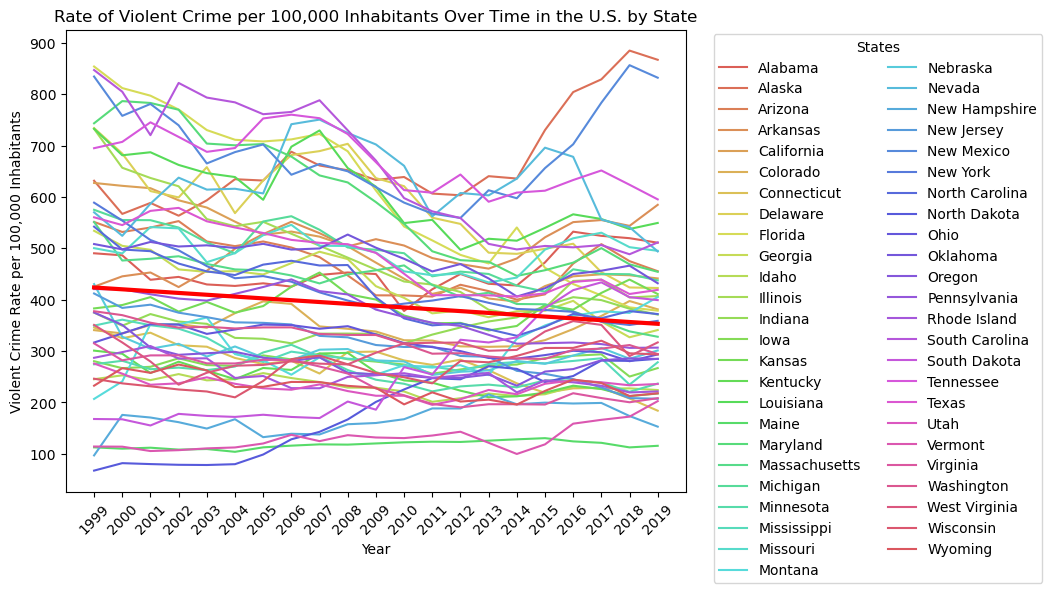

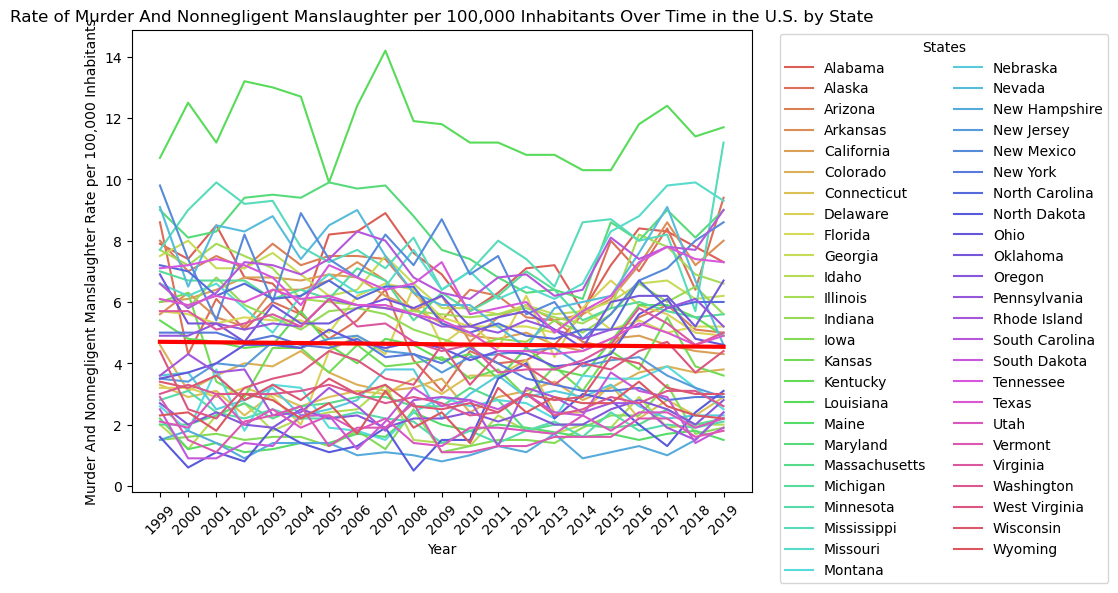

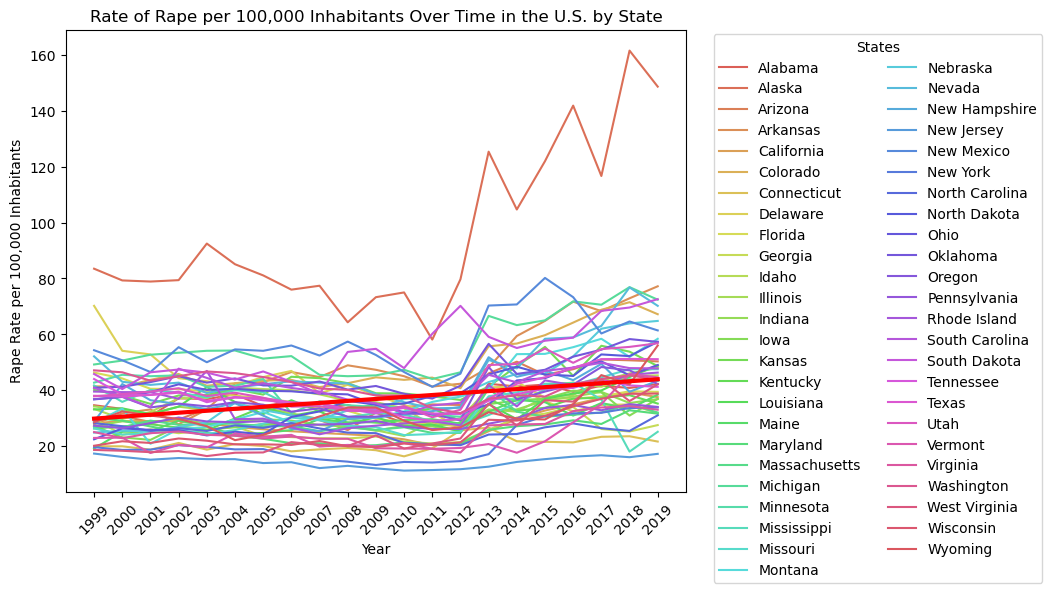

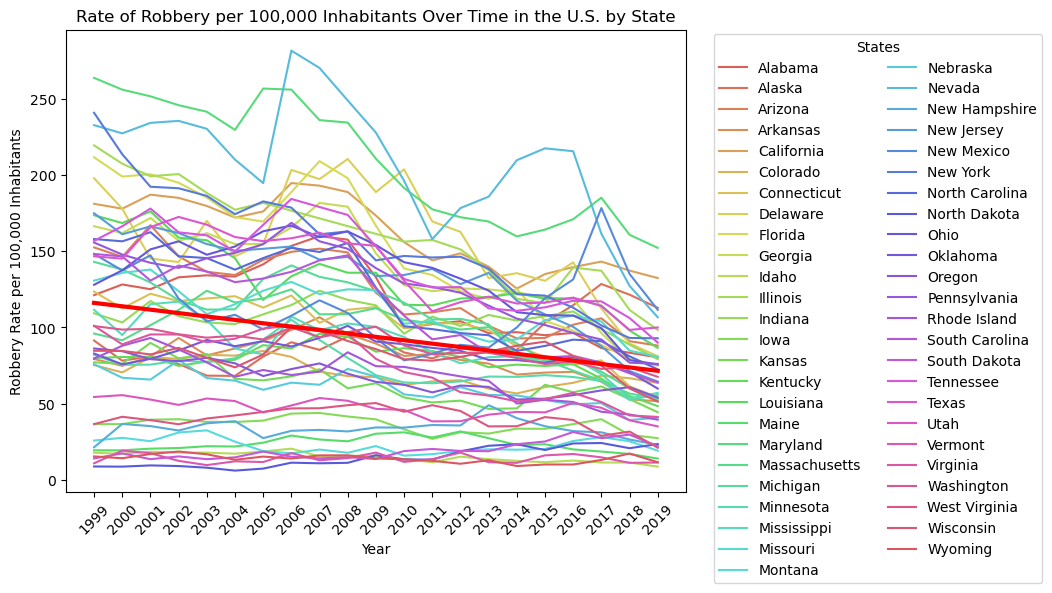

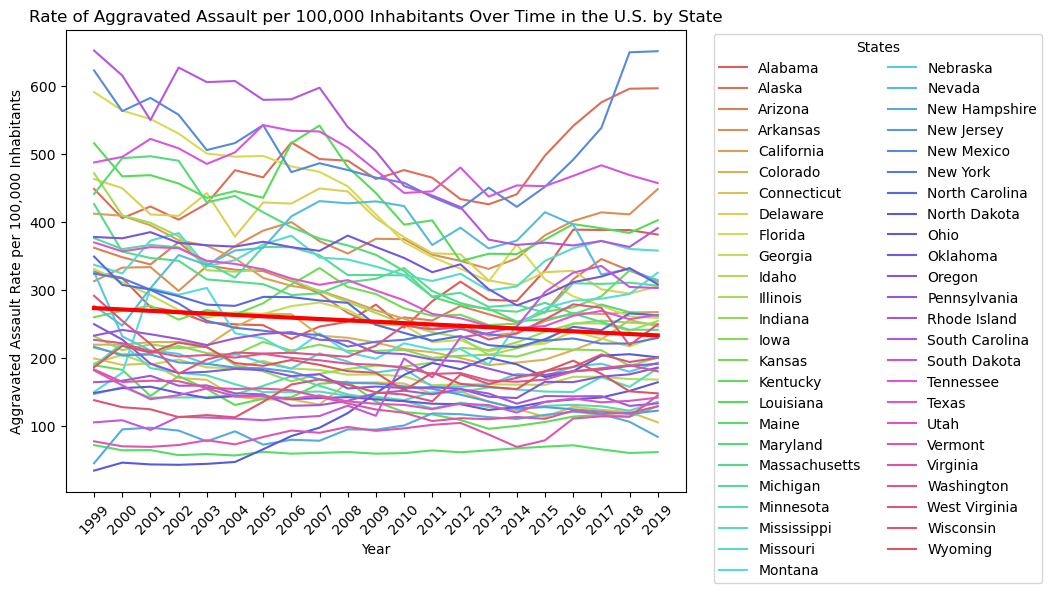

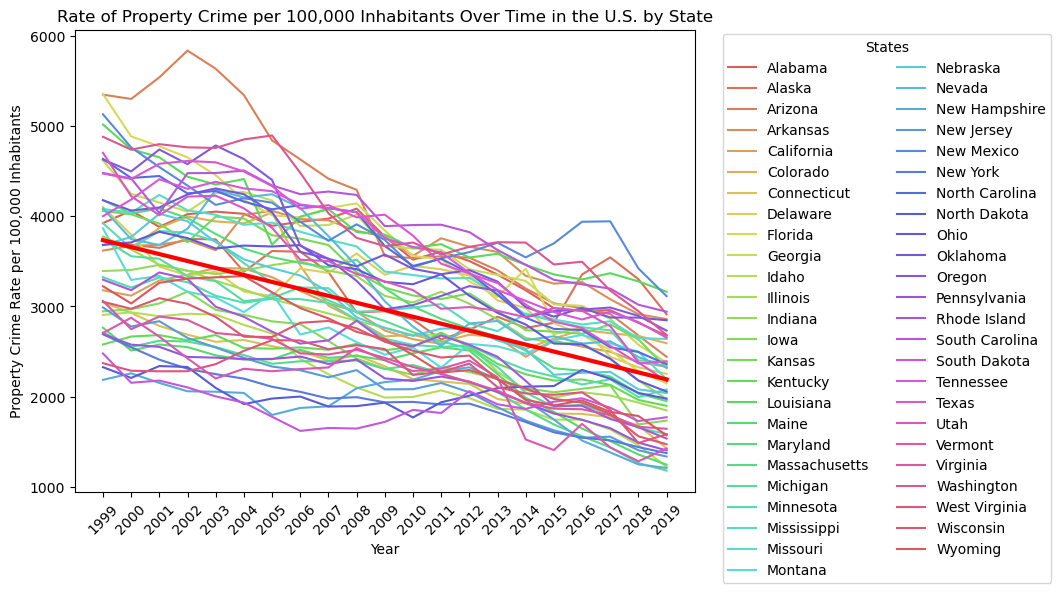

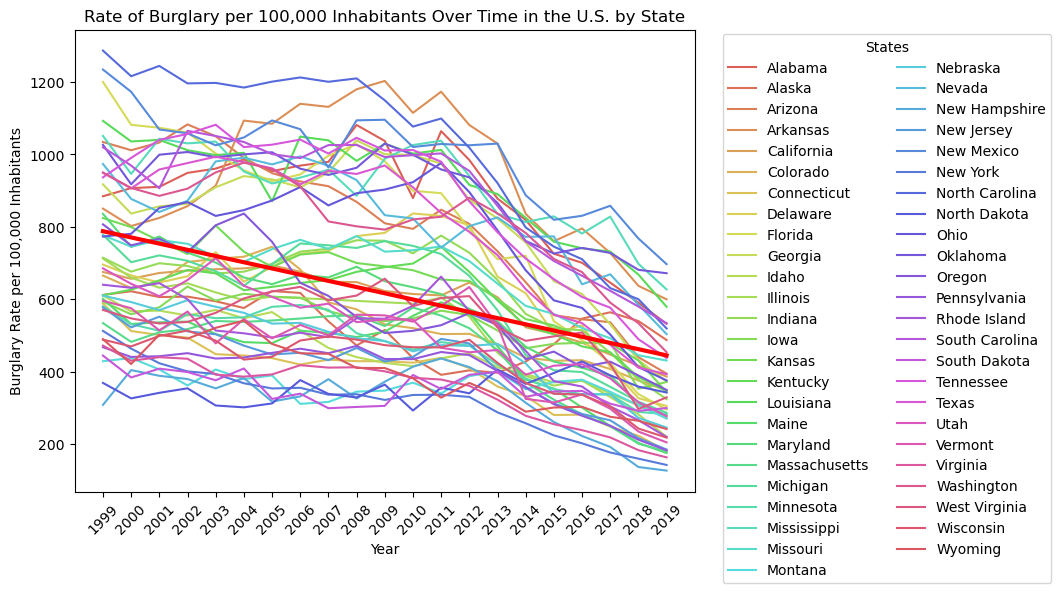

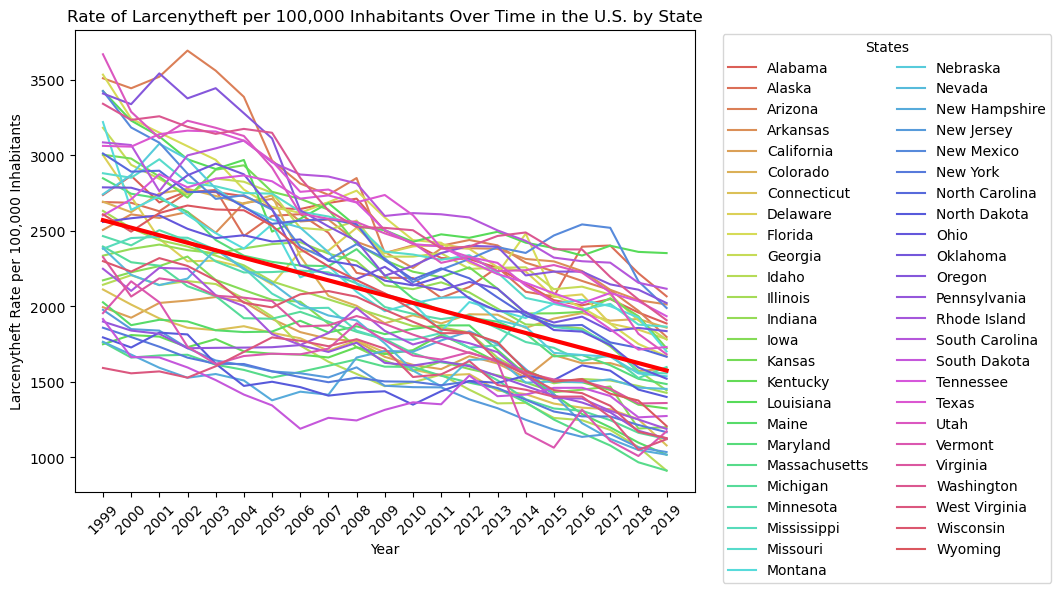

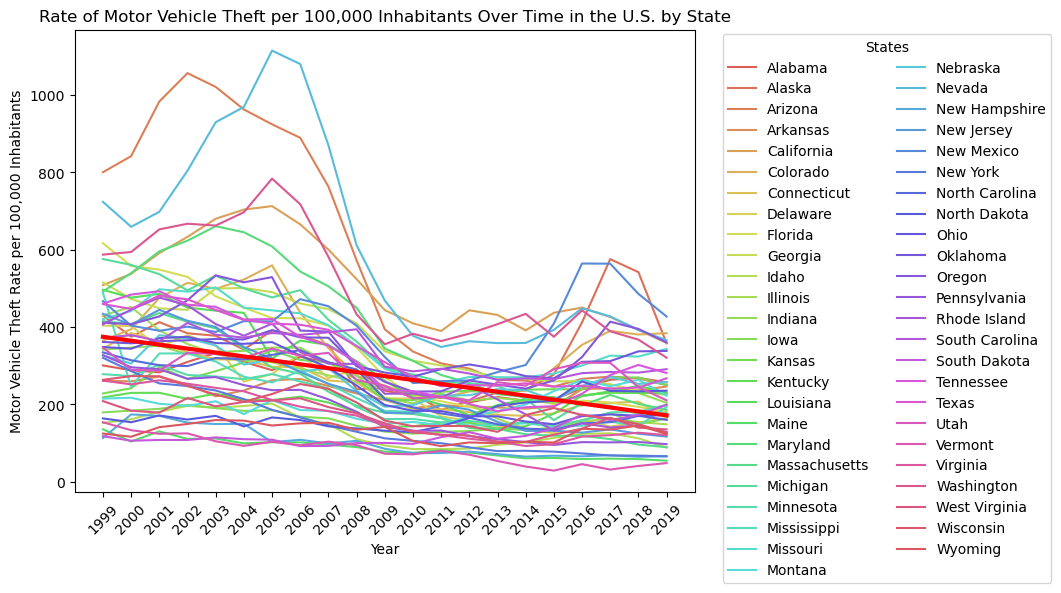

In [15]:
crime = data.copy() # get deep copy of original data

# get columns for crime data only and only rows that contain crime rates
crime = crime[crime['unit_type']=='Rate per 100,000 inhabitants'].iloc[:,0:13]

# plot separate line graphs for U.S. crime rate over time for each type of offense by state
for i in crime.columns[4:]:
    fig, ax = plt.subplots(figsize=(8,6)) # create figure and axis for plot
    sns.lineplot(data=crime, x='year', y=i, hue='state',palette='hls',ax=ax,errorbar=None)
    
    # plot the regression line
    reg = np.polyfit(crime['year'], crime[i], 1)
    trend = np.polyval(reg, crime['year'])
    plt.plot(crime['year'], trend, 'r', linewidth=3)

    # set up the configuration of the legend
    plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left', borderaxespad=2, title='States', ncol=2)

    # set up the xticks
    plt.xticks(np.linspace(1999,2019,21,endpoint=True))
    plt.xticks(rotation=45)

    # set up the title
    s = i.replace('_', ' ').title()
    plt.title('Rate of '+s+' per 100,000 Inhabitants Over Time in the U.S. by State')
    # set up the y-axis label
    plt.ylabel(s+' Rate per 100,000 Inhabitants')
    # set up the x-axis label
    plt.xlabel('Year')

It appears that all crime rates except for rape and murder have decreased over time. Rape is shown to have increased over time and murder is shown to have stayed the same over time from 1999 to 2019.

### Analyzing Median Household Income Data

Text(0.5, 0, 'Year')

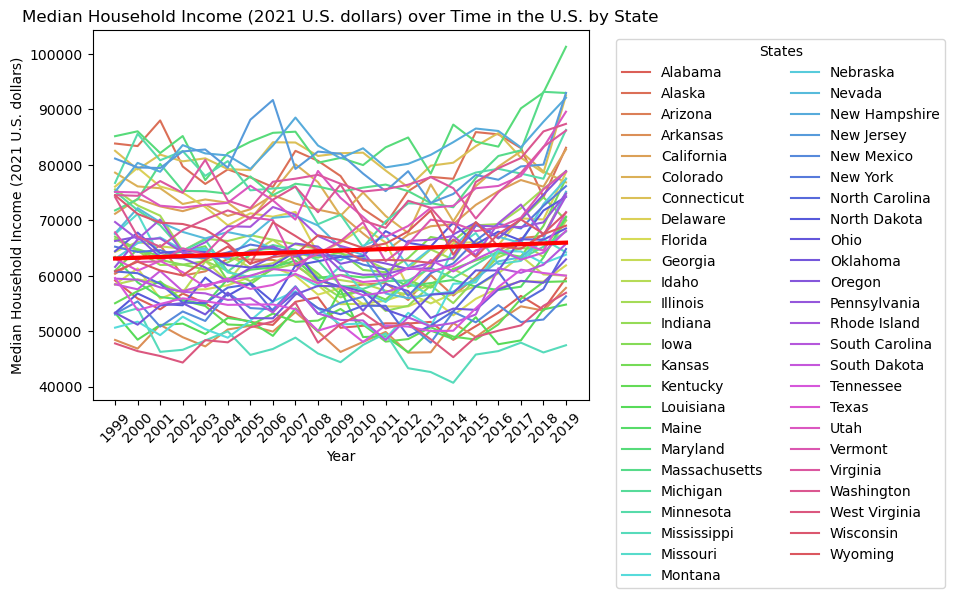

In [16]:
sns.lineplot(data=data, x='year', y='median_household_income', hue='state',palette='hls',errorbar=None)

# plot the regression line
reg = np.polyfit(data['year'], data['median_household_income'], 1)
trend = np.polyval(reg, data['year'])
plt.plot(data['year'], trend, 'r', linewidth=3)

# set up the configuration of the legend
plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left', borderaxespad=2, title='States', ncol=2)

# set up the xticks
plt.xticks(np.linspace(1999,2019,21,endpoint=True))
plt.xticks(rotation=45)

# set up the title
plt.title('Median Household Income (2021 U.S. dollars) over Time in the U.S. by State')
# set up the y-axis label
plt.ylabel('Median Household Income (2021 U.S. dollars)')
# set up the x-axis label
plt.xlabel('Year')

It appears that the median household income has gradually increased over time between 1999 and 2019.

### Analyzing Climate Data
Now we will take a look at the climate-related variables over time.

In [34]:
test = climate.dropna(axis= 0, how='any')
test.head()

year       state  avg_ann_tmp  max_ann_tmp  min_ann_tmp  total_ann_pcp  \
1   1999     Alabama    64.141667         94.2         34.6          49.01   
5   1999     Arizona    60.783333         91.2         28.0          10.37   
7   1999    Arkansas    62.150000         94.9         32.4          43.80   
9   1999  California    57.958333         88.1         33.6          17.63   
11  1999    Colorado    46.641667         82.1         15.2          20.03   

    avg_ann_pdsi  
1      -0.847500  
5      -1.272500  
7      -1.641667  
9      -0.174167  
11      1.031667

In [32]:
climate = data.copy() # get deep copy of original data

# get columns for only climate data for rate per 100,000 inhabitants so there are no duplicates  
climate = climate[climate['unit_type']=='Rate per 100,000 inhabitants'].iloc[:,[0,1,14,15,16,17,18]]

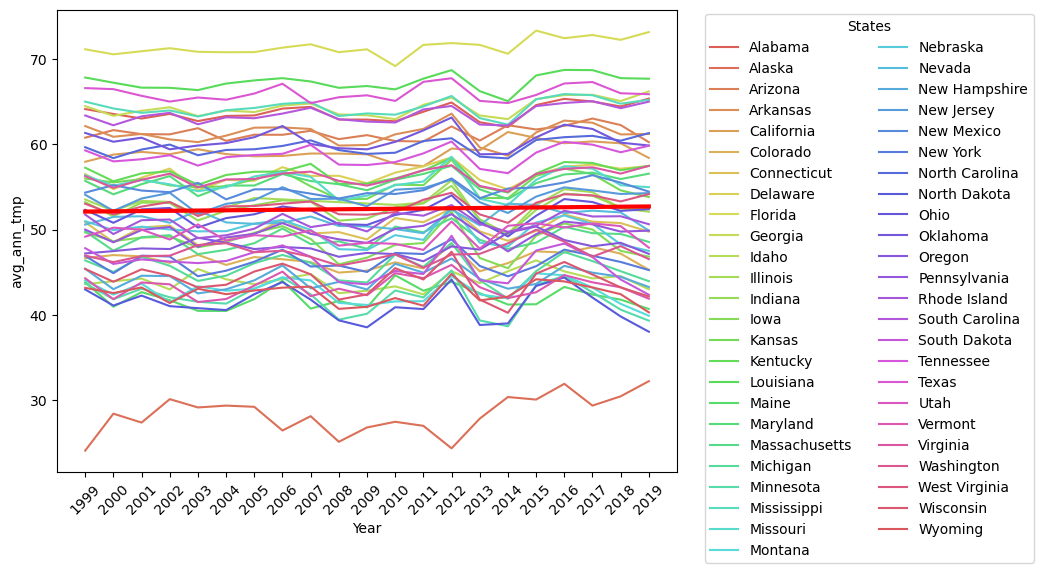

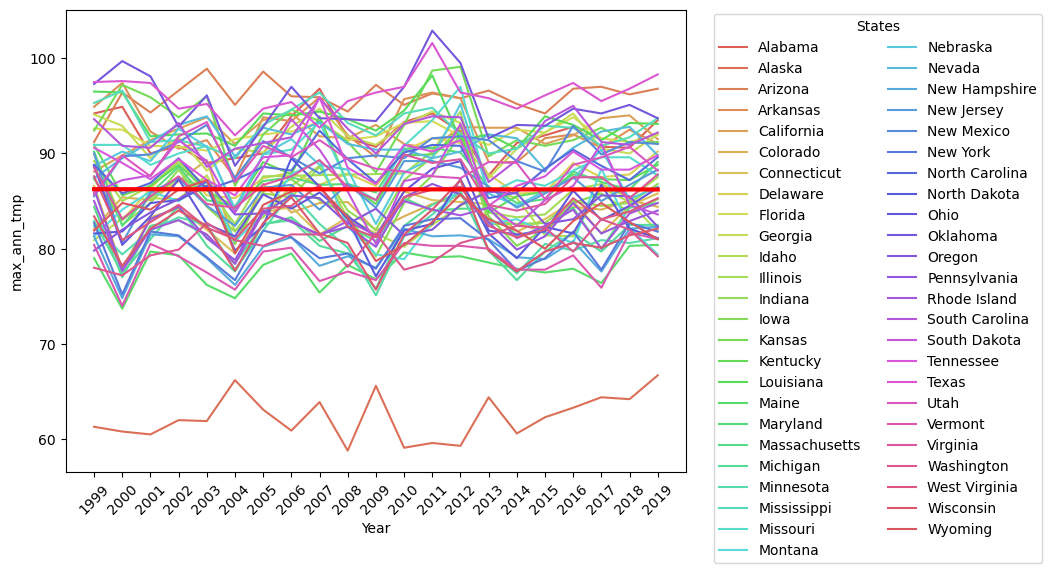

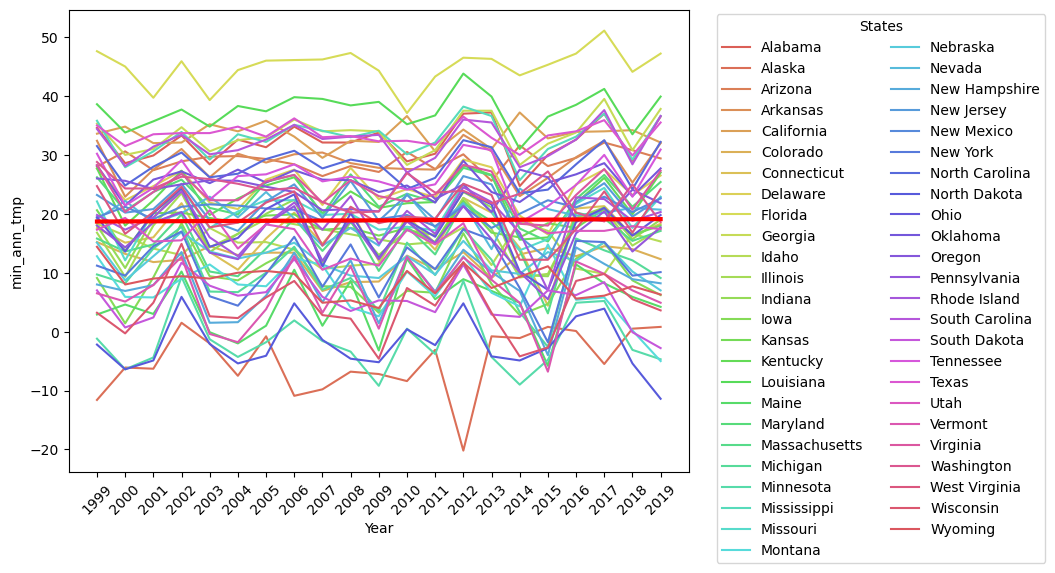

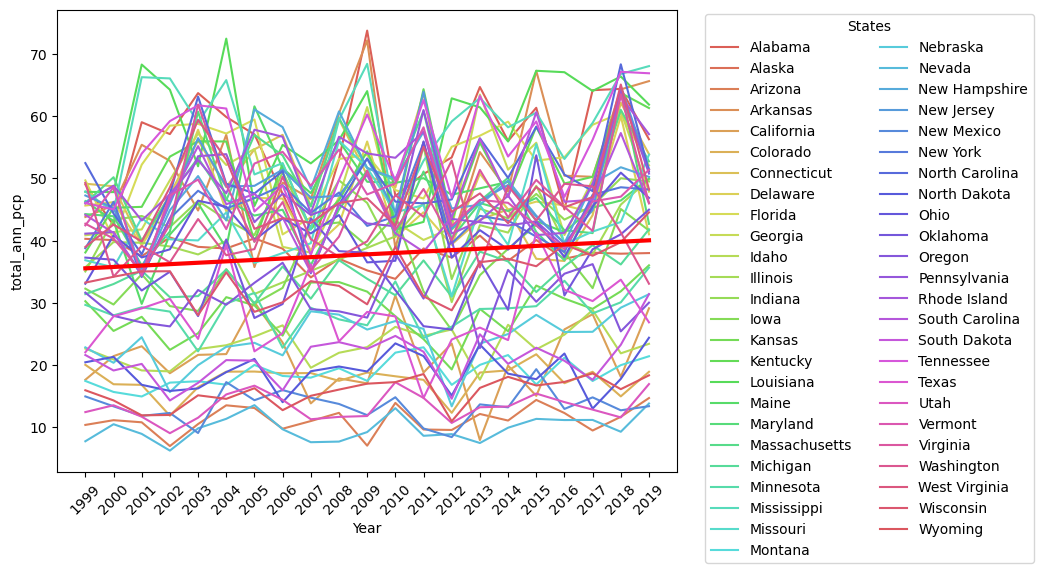

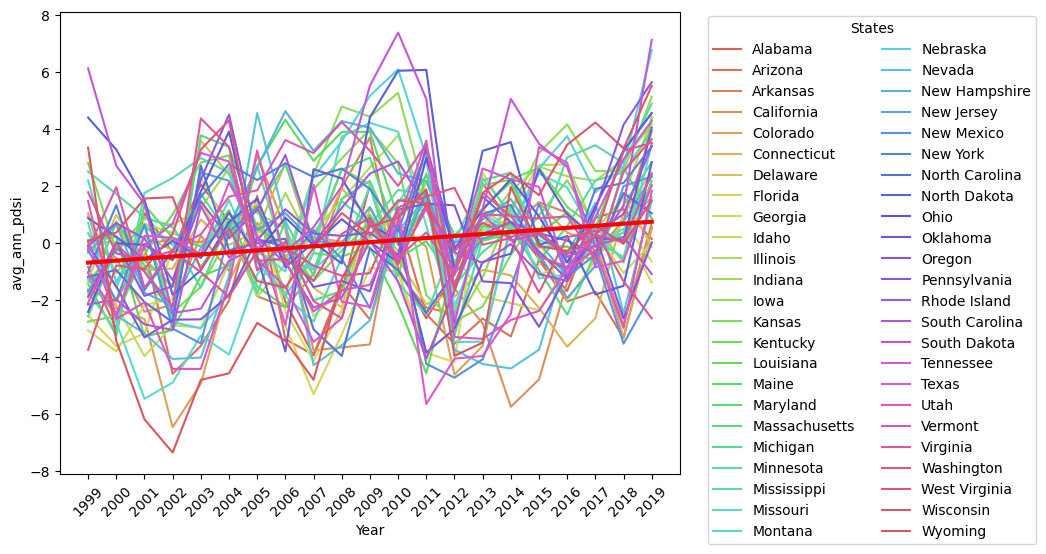

In [35]:
climate_vars = ['avg_ann_tmp', 'max_ann_tmp', 'min_ann_tmp', 'total_ann_pcp', 'avg_ann_pdsi']
# plot separate line graphs for climate variables over time by state
for i in range(len(climate_vars)):
    fig, ax = plt.subplots(figsize=(8,6)) # create figure and axis for plot
    
    if climate_vars[i] == 'avg_ann_pdsi':
        # Alaska is the only state that does not have PDSI values, so we will remove all of its entries for PDSI
        pdsi_climate= climate.dropna(axis= 0, how='any') 
        sns.lineplot(data=pdsi_climate, x='year', y=pdsi_climate[climate_vars[i]], hue='state',palette='hls',ax=ax,errorbar=None)
        reg = np.polyfit(pdsi_climate['year'], pdsi_climate[climate_vars[i]], 1)
    else: # Otherwise, use original climate dataframe
        sns.lineplot(data=climate, x='year', y=climate[climate_vars[i]], hue='state',palette='hls',ax=ax,errorbar=None)
        reg = np.polyfit(climate['year'], climate[climate_vars[i]], 1)
    
    # plot the regression line
    trend = np.polyval(reg, climate['year'])
    plt.plot(climate['year'], trend, 'r', linewidth=3)

    # set up the configuration of the legend
    plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left', borderaxespad=2, title='States', ncol=2)

    # set up the xticks
    plt.xticks(np.linspace(1999,2019,21,endpoint=True))
    plt.xticks(rotation=45)

    # set up the title
    # s = climatei.replace('_', ' ').title()
    # plt.title('Rate of '+s+' Over Time in the U.S. by State')
    # set up the y-axis label
    # plt.ylabel(s+' Rate per 100,000 Inhabitants')
    # set up the x-axis label
    plt.xlabel('Year')

### Pearson Correlation Matrix
A pearson correlation matrix gives the correlations between each variable and every other variable. Looking at these correlation coefficients will tell us which pairs of variables are correlated.

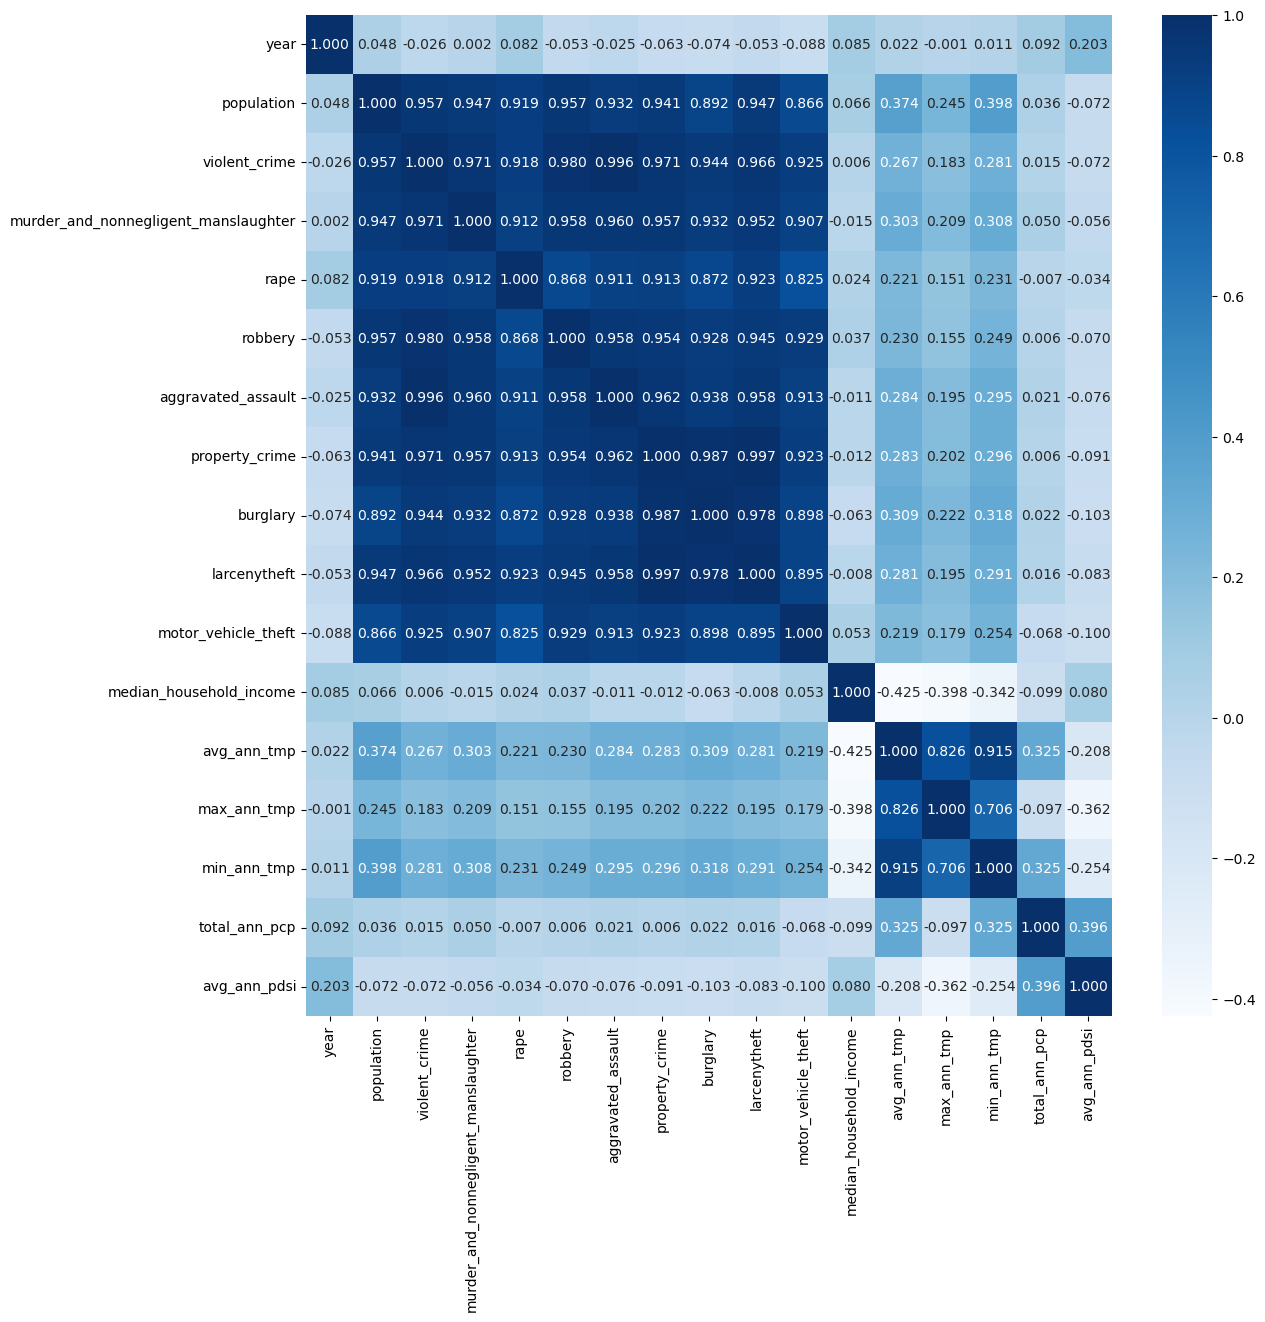

In [23]:
plt.figure(figsize=(13,13))
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="Blues", fmt='.3f')
plt.show()

Based on the Pearson correlation matrix above, population is highly correlated with all forms of crime, crime is slightly correlated with average annual temperature, and median household income is moderately correlated with average annual temperature. All other correlations are either too small to be significant (< 0.2) or are not of importance (e.g. temperature is obviously correlated with precipitation)

## Works Cited
FBI. “Variables Affecting Crime.” Uniform Crime Reporting Program, 2011, https://ucr.fbi.gov/hate-crime/2011/resources/variables-affecting-crime.